#Gender & Age Detection for UTK-Faces using Edge Impulse

## Ressources

*   Edge Impulse CNN-Regression & Classification
*  [ Dataset UTK-Face ](https://www.kaggle.com/datasets/jangedoo/utkface-new) on Kaggel

*   [Ngrok Agent](https://ngrok.com/) for virtual server
*   [Flask Webframework](https://flask.palletsprojects.com/en/3.0.x/) for app rendering

## Project Goal
The goal of the project is to train a computer vision model on [Edge Impulse](https://edgeimpulse.com/) to predict gender and age based on a person’s profile photo. This model will be integrated into a simple frontend with picture upload functionality, allowing for on-the-fly use without relying on on-premise installations.

The models were trained on approx. 23k images, all labeled with their gender (female/male) and age (1-116) with a 80/20 test split.

# Install and Import Necessary Ressources

In [98]:
!pip install flask pyngrok
!pip install tflite-runtime


from flask import Flask, render_template_string, request, jsonify, send_file
import cv2
import numpy as np
import tensorflow as tf
import os
import base64
from io import BytesIO
from PIL import Image
from pyngrok import ngrok

# Prepare Flask-App

In [99]:
app = Flask(__name__)

# Prepare Frontend Code

The fronend contains a (dramatic) background picture, made with [leonardo.ai](https://www.leonardo.ai) and uses simple CSS and JavaScript elements to produce a picture upload area and the AI generated results after upload.

The frontend is in German.

In [100]:
# HTML Inhalt
html = '''
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Face Your Age!</title>
        <link href="https://fonts.googleapis.com/css2?family=Orbitron:wght@400;700&display=swap" rel="stylesheet">
        <style>
            body {
                font-family: 'Orbitron', sans-serif;
                text-align: center;
                background-image: url('https://cdn.leonardo.ai/users/3b6c7a1b-3c4c-41ad-95eb-c041cde7a6c9/generations/19330bf5-a67f-4be5-abc2-f2fcf37a57ba/Default_Create_a_photorealistic_genderneutral_face_against_a_d_0.jpg');
                background-size: cover;
                background-position: center;
                background-repeat: no-repeat;
                height: 100vh;
                margin: 0;
                color: #42d9c8;
                display: flex;
                justify-content: center;
                align-items: center;
                flex-direction: column;
            }

            h1 {
                font-size: 5em;
            }

            .upload-area {
                border: 2px dashed #42d9c8;
                color: #42d9c8;
                background-color: rgba(50, 103, 113, 0.8);
                padding: 20px;
                margin: 10px;
                border-radius: 10px;
                width: fit-content;
                text-align: inline-block;
            }

            .upload-area.dragover {
                background-color: rgba(66, 217, 200, 0.8);
            }

            input[type="file"] {
                display: none;
            }

            button {
                border: 2px solid #42d9c8;
                color: #42d9c8;
                background-color: rgba(50, 103, 113, 0.8);
                padding: 10px;
                margin: 5px;
                border-radius: 5px;
                cursor: pointer;
            }

            .loading-animation {
                border: 16px solid #f3f3f3;
                border-top: 16px solid #42d9c8;
                border-radius: 50%;
                width: 120px;
                height: 120px;
                animation: spin 2s linear infinite;
                margin-top: 20px;
            }

            @keyframes spin {
                0% { transform: rotate(0deg); }
                100% { transform: rotate(360deg); }
            }

           #result {
                font-size: 2em;
                border: 2px solid #42d9c8;
                color: #42d9c8;
                background-color: rgba(50, 103, 113, 0.8);
                padding: 20px;
                margin: 10px;
                border-radius: 10px;
                width: fit-content;
                display: none; // Hide result area until content is available
            }

            #uploaded-image {
                margin-top: 20px;
                max-width: 100%;
                border: 2px solid #42d9c8;
                border-radius: 10px;
            }

            #back-button {
                margin-top: 20px;
            }
        </style>
    </head>
    <body>
        <h1>Face Your Age!</h1>
        <form id="upload-form" enctype="multipart/form-data">
            <div class="upload-area" id="upload-area">
                Ziehe dein Bild hierher oder klicke, um es auszuwählen
                <input type="file" name="file" id="file-input">
            </div>
            <button type="submit">Guess My Age</button>
        </form>
        <div id="loading" class="loading-animation" style="display: none;"></div>
        <div id="result"></div>
        <img id="uploaded-image" src="" alt="Uploaded Image" style="display: none;">
        <button id="back-button" style="display: none;">Zurück</button>

        <script>
            const uploadArea = document.getElementById('upload-area');
            const fileInput = document.getElementById('file-input');
            const form = document.getElementById('upload-form');
            const loading = document.getElementById('loading');
            const resultDiv = document.getElementById('result');
            const uploadedImage = document.getElementById('uploaded-image');
            const backButton = document.getElementById('back-button');

            uploadArea.addEventListener('click', () => fileInput.click());

            uploadArea.addEventListener('dragover', (event) => {
                event.preventDefault();
                uploadArea.classList.add('dragover');
            });

            uploadArea.addEventListener('dragleave', () => {
                uploadArea.classList.remove('dragover');
            });

            uploadArea.addEventListener('drop', (event) => {
                event.preventDefault();
                uploadArea.classList.remove('dragover');
                const files = event.dataTransfer.files;
                if (files.length > 0) {
                    fileInput.files = files;
                    uploadArea.textContent = files[0].name;
                }
            });

            fileInput.addEventListener('change', () => {
                if (fileInput.files.length > 0) {
                    uploadArea.textContent = fileInput.files[0].name;
                }
            });

            form.addEventListener('submit', (event) => {
                event.preventDefault();
                if (fileInput.files.length === 0) {
                    alert("Bitte wähle eine Datei aus, bevor du fortfährst.");
                    return;
                }

                const formData = new FormData();
                formData.append('file', fileInput.files[0]);

                form.style.display = 'none';
                loading.style.display = 'block';

                fetch('/predict', {
                    method: 'POST',
                    body: formData
                })
                .then(response => response.json())
                .then(data => {
                    loading.style.display = 'none';
                    if (data.error) {
                        resultDiv.textContent = `Fehler: ${data.error}`;
                    } else {
                        const gender = data.gender;
                        const age = data.age.toFixed(2);
                        resultDiv.textContent = `Du bist ${gender} und in etwa ${age} Jahre alt.`;
                        resultDiv.style.display = 'block';  // Only show resultDiv when content is not empty

                        uploadedImage.src = `data:image/jpeg;base64,${data.image}`;
                        uploadedImage.style.display = 'block';
                    }
                    backButton.style.display = 'block';
                })
                .catch(error => {
                    loading.style.display = 'none';
                    console.error('Error:', error);
                    resultDiv.textContent = 'Fehler bei der Vorhersage.';
                    backButton.style.display = 'block';
                });
            });

            backButton.addEventListener('click', () => {
                location.reload();
            });
        </script>
    </body>
    </html>
    '''


# Image Preparation

To ensure compatibility with the model, all images are scaled and quantized.

In [101]:
def prepare_image(image, input_details):
    img = cv2.resize(image, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    input_scale, input_zero_point = input_details[0]['quantization']
    img = img / 255.0
    img = img / input_scale + input_zero_point
    img = np.round(img).astype(np.int8)
    img = np.expand_dims(img, axis=0)
    return img

# Load and Run Model

Set up interpreters and tensors for the use of the Edge Impulse Model. Make sure you use the prepared image from step above.

## Model Performance Gender Classification


*   Accuracy: 86,44 %
*   Weighted average Precision: 0,90
*   Weighted average Recall: 0,90
*   Weighted average F1 score: 0,90


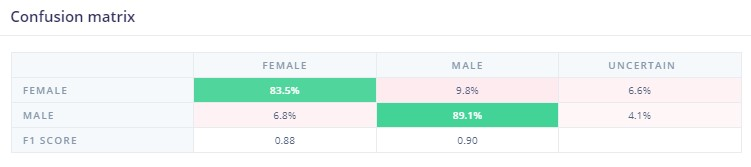

## Model Performance Age Regression


*   Accuracy: 77,17 %
*   Mean squared error: 103,08
*   Mean absolute error: 7,75
*   Explained variance score: 0,74

In [102]:
def load_and_run_model(model_path, img):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    prepared_image = prepare_image(img, input_details)
    interpreter.set_tensor(input_details[0]['index'], prepared_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    if output_details[0]['dtype'] == np.int8:
        output_scale, output_zero_point = output_details[0]['quantization']
        output = output_scale * (output.astype(np.float32) - output_zero_point)

    return output

# Starting App

First render the frontend html to be used in the app.
Then create a POST-function to the predict route created in load_and_run_model step, that returns the gender & age prediction.

Two Edge Impulse models are used: CNN-Regression for age prediction and Classification for gender prediction.
The models were deployed on Edge Impuls via a custom deployment block to extract the Tensorflow Lite Models:


*   age_trained.tflite
*   gender_trained.tflite



In [103]:
@app.route('/')
def index():
    return render_template_string(html)

In [104]:
@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400

    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No file selected'}), 400

    # Temporäre Datei speichern
    temp_path = './temp_image.jpg'
    file.save(temp_path)

    # Bild lesen
    img = cv2.imread(temp_path)

    # Pfade zu den Modellen
    age_model_path = "/content/age_trained.tflite"
    gender_model_path = "/content/gender_trained.tflite"

    # Vorhersage für das Alter
    age_prediction = load_and_run_model(age_model_path, img)
    predicted_age = float(age_prediction[0][0])

    # Vorhersage für das Geschlecht
    gender_prediction = load_and_run_model(gender_model_path, img)
    female_prob = float(gender_prediction[0][0])
    male_prob = float(gender_prediction[0][1])
    gender_label = "Weiblich" if female_prob > male_prob else "Männlich"

    # Bild in Base64 umwandeln
    pil_image = Image.open(temp_path)
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()

    # Entfernen der temporären Datei
    os.remove(temp_path)

    return jsonify({'age': predicted_age, 'gender': gender_label, 'image': img_str})

# Initializing ngrok Server


[ngrok](https://ngrok.com/) creates a virtual server to run the Flask app. It requires an authtoken to be used and generates a publicly available URL.



In [105]:
!ngrok authtoken 2kYRP0TAMP5cl8jkBKhQM77GkUa_sgYBn5R5c95ETQ3qdZ34


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
if __name__ == '__main__':
    port = 5001
    public_url = ngrok.connect(port).public_url  # Start ngrok first
    print(' * Running on external URL: {}'.format(public_url))
    app.run(host='0.0.0.0', port=port, debug=False)  # Then start Flask

 * Running on external URL: https://2c6a-104-197-121-86.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://172.28.0.12:5001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [14/Aug/2024 10:24:24] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Aug/2024 10:24:25] "GET /favicon.ico HTTP/1.1" 404 -
